#**K-Means**

Conventional k-means requires only a few steps. The first step is to randomly select k centroids, where k is equal to the number of clusters you choose. Centroids are data points representing the center of a cluster.

The main element of the algorithm works by a two-step process called expectation-maximization. The expectation step assigns each data point to its nearest centroid. Then, the maximization step computes the mean of all the points for each cluster and sets the new centroid. Here’s what the conventional version of the k-means algorithm looks like:

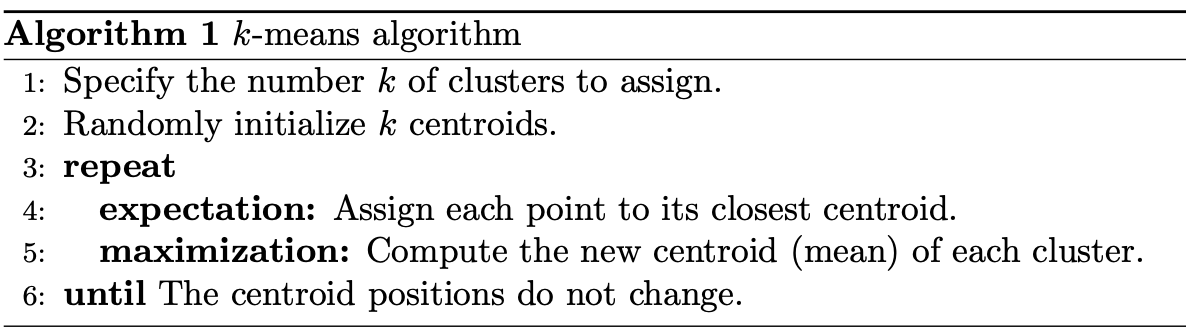

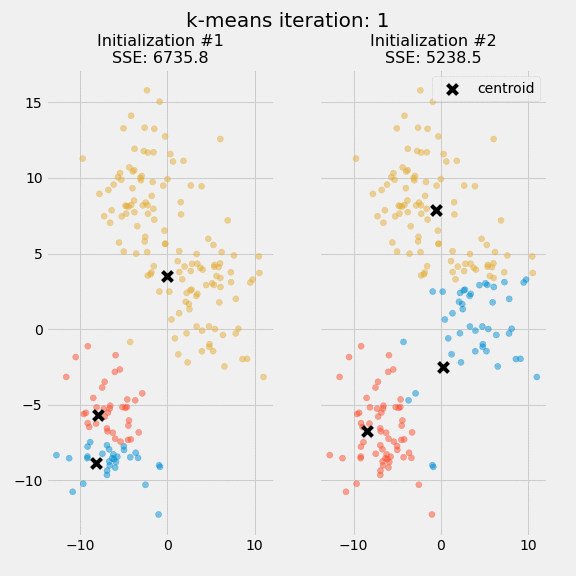

##***Disadvantages of K-Means***

* The number of clusters has to be set in the beginning
* The results depend on the inital cluster centers
* It's sensitive to outliers
* It's not suitable for finding non-convex clusters
* It's not guaranteed to find a global optimum, so it can get stuck in a local minimum


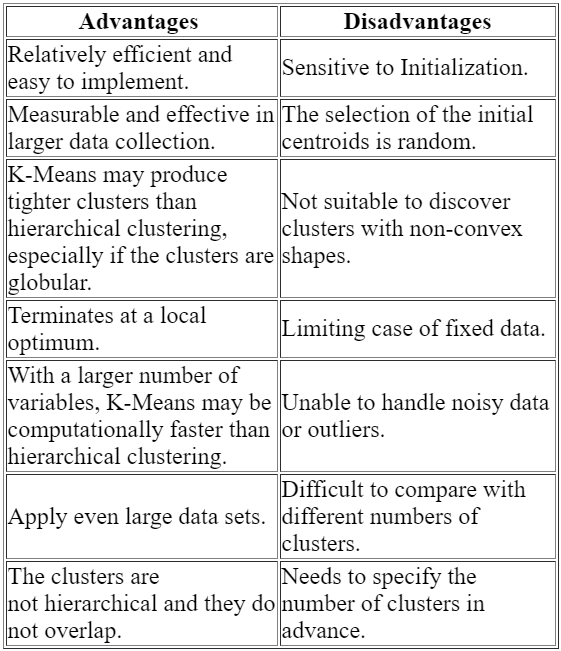

In [ ]:
# import the necessary libraries

import math

import numpy as np
import pandas as pd

In [ ]:
# import the dataset

# Dataset downloaded from: https://download.data.world/datapackage/environmentdata/iris-species
df = pd.read_csv("iris.csv")

# fetch all features into different lists

f1 = df['sepal_length'].values
f2 = df['sepal_width'].values
f3 = df['petal_length'].values
f4 = df['petal_width'].values
species = df['species'].values

# Storing original data into an array
original_data = np.array(list(zip(species, f1, f2, f3, f4)))

# data array with only the features which will be used to cluster the data
data = np.array(list(zip(f1, f2, f3, f4)))


In [ ]:
def init_centroids(k, data):
    '''
        This function will be used to initialize the centroids once in the beginning.
        Centroids will be randomly chosen as points(features) from the dataset, as this provides faster
        convergence. Another implementation
        can be assigning completely random numbers as centroids, but this is dangerous.
        :param k: (int) number of centroids
        :param data: (np-array) containing the features of the dataset
        :return: (list) 'k' number of randomly selected centroids from the dataset
        '''
    c = []
    # Generate a list of k random numbers between 0 and the # of features of dataset
    s = np.random.randint(low=1, high=len(data), size=k)
    # Check if all members of 's' are unique, if not, generate again
    while (len(s) != len(set(s))):
        s = np.random.randint(low=1, high=len(data), size=k)
    # For every i in s, get ith feature from dataset, and add it to list
    for i in s:
        c.append(data[i])
    return c

def euc_dist(a, b):
    '''
    This function calculates and returns the euclidean distance between two input vectors.
    This is a helper function for cal_dist() to calculate distance of any given point in
    data w.r.t. the centroids.
    :param a: (list) vector a
    :param b: (list) vector b
    :return: (float) euclidean distance between two input vectors
    '''
    sum = 0
    for i, j in zip(a, b):
        a = (i - j) * (i - j)
        sum = sum + a
    return math.sqrt(sum)

In [ ]:
def cal_dist(centroids, data):
    '''
    This function will be used to generate the distance table.
    For each point in the given dataset, this function will calculate its euclidean distance
    with respect to each centroid, and a distance table will be generated, which will then be
    used to update the centroid positions.
    :param centroids: (list) containing position of centroids
    :param data: (np-array) containing the features of the dataset
    :return: (list) containing the distances of each point w.r.t. each centroid
    '''
    c_dist = []
    # For each centroid c, iterate through all points in data to calculate its distance from c
    for i in centroids:
        temp = []
        for j in data:
            temp.append(euc_dist(i, j))
        c_dist.append(temp)
    return c_dist

In [ ]:
def perf_clustering(k, dist_table):
    '''
    This function will perform clustering on the basis of distance table w.r.t. to all centroids.
    With reference to the distance table, for each point in the table, this function will compare
    its distance from all the centroids, and then cluster the point with the nearest centroid.
    :param k: (int) number of centroids
    :param dist_table: (list) containing the distances of each point w.r.t. each centroid
    :return: (list) containing clusters and indexes of respective members
    '''
    # create empty cluster list of size k
    clusters = []
    for i in range(k):
        clusters.append([])
    # start clustering data points, such that each point is clustered to nearest centroid
    for i in range(len(dist_table[0])):
        d = []
        for j in range(len(dist_table)):
            d.append(dist_table[j][i])
        clusters[d.index(min(d))].append(i)
    return clusters

In [ ]:
def update_centroids(centroids, cluster_table, data):
    '''
    This function will update the centroids locations after each iteration
    After performing the clustering, some elements might have migrated from one cluster
    to the another cluster, so w.r.t. the new cluster table, this function will calculate and
    update the new centroid locations
    :param centroids: (list) containing position of centroids
    :param cluster_table: (list) containing clusters and indexes of respective members
    :param data: (np-array) containing the features of the dataset
    :return: (list) containing updated position of centroids
    '''
    for i in range(len(centroids)):
        # Update the centroid if there are some flowers within this centroid
        if (len(cluster_table[i]) > 0):
            temp = []
            # Copy features of cluster members to temp list
            for j in cluster_table[i]:
                temp.append(list(data[j]))
            # Take mean of features of all members of cluster to get new centroid location
            sum = [0] * len(centroids[i])
            for l in temp:
                sum = [(a + b) for a, b in zip(sum, l)]
            centroids[i] = [p / len(temp) for p in sum]

    return centroids

In [ ]:
def check_n_stop(dist_mem, cluster_mem):
    '''
    This function will check if the stopping criteria has been met
    This function will help to check if there is a convergence to a solution, with the help of
    specified stopping criterias:
    In case of Iris-Dataset, we can use the following stopping criterias:
    --[1] The euclidean distances/distance table stays unchanged for 2 or more iterations.
    --[2] The cluster table stays unchanged for two or more iterations, i.e. no flower migrations
    :param dist_table: (list) containing the distances of each point w.r.t. each centroid
    :param cluster_table: (list) containing clusters and indexes of respective members
    :return: True, if stopping criteria is met, else False.
    '''

    # Check if distance table has not changed over past iterations
    c1 = all(x == dist_mem[0] for x in dist_mem)
    # Check if cluster table has not changed over past iterations
    c2 = all(y == cluster_mem[0] for y in cluster_mem)

    if c1:
        print("Stopping... Distance table has not changed from few iterations")
    elif c2:
        print("Stopping... Cluster table has not changed from few iterations")
    return c1 or c2


In [ ]:
def kMeans(k, data, max_iterations):
    '''
    Simple implementation of K-Means algorithm
    This function is a very naive implementation of the K-Means algorithm.
    Steps:
    --[1] Initialize random centroids
    --[2] Calculate distances for each point w.r.t. centroid, and store them in distance table.
    --[3] Perform clustering with the available distance table
    --[4] Update the centroid positions
    --[5] Stop if stopping criteria is met, else repeat again from --[2]
    :param k: (int) number of centroids
    :param data: (np-array) containing the features of the dataset
    :param max_iterations: (int) number of maximum iterations allowed.
    :return: none
    '''
    # These lists will maintain memory to check if stopping criteria is met
    dist_mem = []
    cluster_mem = []

    # Initialize centroids
    centroids = init_centroids(k, data)
    # Calculate distance table
    distance_table = cal_dist(centroids, data)
    # Perform clustering based on above generated distance table
    cluster_table = perf_clustering(k, distance_table)
    # Update centroid location based on above generated cluster table
    newCentroids = update_centroids(centroids, cluster_table, data)

    # Add distance and cluster table to memory list
    dist_mem.append(distance_table)
    cluster_mem.append(cluster_table)

    # Repeat from step 2 till stopping criteria is met
    for i in range(max_iterations):
        distance_table = cal_dist(newCentroids, data)
        cluster_table = perf_clustering(k, distance_table)
        newCentroids = update_centroids(newCentroids, cluster_table, data)

        # Check for stopping criteria
        # Maintain memory for past distance table and cluster table
        dist_mem.append(distance_table)
        cluster_mem.append(cluster_table)
        # If distance/cluster has not changed over last 10 iterations, stop, else continue
        if len(dist_mem) > 10:
            dist_mem.pop(0)
            cluster_mem.pop(0)
            if check_n_stop(dist_mem, cluster_mem):
                print("Stopped at iteration #", i)
                break

    # Display the final results
    for i in range(len(newCentroids)):
        print("Centroid #", i, ": ", newCentroids[i])
        print("Members of the cluster: ")
        for j in range(len(cluster_table[i])):
            print(original_data[cluster_table[i][j]])




In [ ]:

# Run the K-Means algorithm on the Iris-Dataset with k = 3, and max-iterations limited to 100
kMeans(3, data, 100)

Stopping... Cluster table has not changed from few iterations
Stopped at iteration # 13
Centroid # 0 :  [6.8500000000000005, 3.073684210526315, 5.742105263157893, 2.0710526315789473]
Members of the cluster: 
['versicolor' '6.9' '3.1' '4.9' '1.5']
['versicolor' '6.7' '3.0' '5.0' '1.7']
['virginica' '6.3' '3.3' '6.0' '2.5']
['virginica' '7.1' '3.0' '5.9' '2.1']
['virginica' '6.3' '2.9' '5.6' '1.8']
['virginica' '6.5' '3.0' '5.8' '2.2']
['virginica' '7.6' '3.0' '6.6' '2.1']
['virginica' '7.3' '2.9' '6.3' '1.8']
['virginica' '6.7' '2.5' '5.8' '1.8']
['virginica' '7.2' '3.6' '6.1' '2.5']
['virginica' '6.5' '3.2' '5.1' '2.0']
['virginica' '6.4' '2.7' '5.3' '1.9']
['virginica' '6.8' '3.0' '5.5' '2.1']
['virginica' '6.4' '3.2' '5.3' '2.3']
['virginica' '6.5' '3.0' '5.5' '1.8']
['virginica' '7.7' '3.8' '6.7' '2.2']
['virginica' '7.7' '2.6' '6.9' '2.3']
['virginica' '6.9' '3.2' '5.7' '2.3']
['virginica' '7.7' '2.8' '6.7' '2.0']
['virginica' '6.7' '3.3' '5.7' '2.1']
['virginica' '7.2' '3.2' '6.0'